In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
hapag=pd.read_excel("BASE DE DATOS.xlsx",sheet_name="Hapag",index_col=0)
hapag.head()

,Validity To,Container Type,Currency All-in Rate,All-in Rate,Currency Ocean Freight,Ocean Freight Rate
Validity From,,,,,,
2021-12-01,2021-12-31,20GP,USD,7696,USD,7696
2022-01-01,2022-01-20,20GP,USD,7448,USD,7448
2022-01-21,2022-02-14,20GP,USD,6448,USD,6448
2022-02-15,2022-02-20,20GP,USD,6448,USD,6448
2022-02-21,2022-02-28,20GP,USD,6448,USD,6448


In [3]:
freight_df = pd.DataFrame({'Ocean Freight rate':hapag["Ocean Freight Rate"]})
freight_df['Seconds'] = freight_df.index.map(pd.Timestamp.timestamp)
freight_df

,Ocean Freight rate,Seconds
Validity From,,
2021-12-01,7696,1.638317e+09
2022-01-01,7448,1.640995e+09
2022-01-21,6448,1.642723e+09
2022-02-15,6448,1.644883e+09
2022-02-21,6448,1.645402e+09
...,...,...
2023-01-13,52,1.673568e+09
2023-02-01,302,1.675210e+09
2023-02-07,302,1.675728e+09


In [4]:
day = 60*60*24 #segundos por día
year = 365.2425*day #segundos por año

freight_df['Day sin'] = np.sin(freight_df['Seconds'] * (2* np.pi / day))
freight_df['Day cos'] = np.cos(freight_df['Seconds'] * (2 * np.pi / day))
freight_df['Year sin'] = np.sin(freight_df['Seconds'] * (2 * np.pi / year))
freight_df['Year cos'] = np.cos(freight_df['Seconds'] * (2 * np.pi / year))
freight_df.head()

,Ocean Freight rate,Seconds,Day sin,Day cos,Year sin,Year cos
Validity From,,,,,,
2021-12-01,7696,1.638317e+09,-1.093976e-11,1.0,-0.502577,0.864532
2022-01-01,7448,1.640995e+09,-8.652299e-12,1.0,0.006709,0.999977
2022-01-21,6448,1.642723e+09,-9.993018e-12,1.0,0.343616,0.939110
2022-02-15,6448,1.644883e+09,-4.392959e-12,1.0,0.703872,0.710327
2022-02-21,6448,1.645402e+09,-7.705558e-12,1.0,0.773313,0.634024


In [5]:
def df_to_X_y2(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [7]:
freight_df=freight_df.drop("Seconds",axis=1)
freight_df.head()

,Ocean Freight rate,Day sin,Day cos,Year sin,Year cos
Validity From,,,,,
2021-12-01,7696,-1.093976e-11,1.0,-0.502577,0.864532
2022-01-01,7448,-8.652299e-12,1.0,0.006709,0.999977
2022-01-21,6448,-9.993018e-12,1.0,0.343616,0.939110
2022-02-15,6448,-4.392959e-12,1.0,0.703872,0.710327
2022-02-21,6448,-7.705558e-12,1.0,0.773313,0.634024


In [8]:
freight_sc=(freight_df["Ocean Freight rate"]-np.mean(freight_df["Ocean Freight rate"]))/np.std(freight_df["Ocean Freight rate"])
freight_sc

Validity From
2021-12-01    1.759329
2022-01-01    1.660384
2022-01-21    1.261411
2022-02-15    1.261411
2022-02-21    1.261411
                ...   
2023-01-13   -1.290419
2023-02-01   -1.190676
2023-02-07   -1.190676
2023-02-15   -1.110881
2023-02-17   -1.110881
Name: Ocean Freight rate, Length: 68, dtype: float64

In [9]:
standard_freight=pd.DataFrame({"Ocean Freight":freight_sc})
new=freight_df.iloc[:,[1,2,3,4]]
data_final=pd.concat([standard_freight,new],axis=1)
data_final.head()

,Ocean Freight,Day sin,Day cos,Year sin,Year cos
Validity From,,,,,
2021-12-01,1.759329,-1.093976e-11,1.0,-0.502577,0.864532
2022-01-01,1.660384,-8.652299e-12,1.0,0.006709,0.999977
2022-01-21,1.261411,-9.993018e-12,1.0,0.343616,0.939110
2022-02-15,1.261411,-4.392959e-12,1.0,0.703872,0.710327
2022-02-21,1.261411,-7.705558e-12,1.0,0.773313,0.634024


In [10]:
xtrain,ytrain=df_to_X_y2(data_final,window_size=3)
xtrain.shape,ytrain.shape

((65, 3, 5), (65,))

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [12]:
model=Sequential()
model.add(InputLayer((3,5)))
model.add(LSTM(40)) 
model.add(Dense(8,"relu")) 
model.add(Dense(1,"linear")) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                7360      
                                                                 
 dense (Dense)               (None, 8)                 328       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 7,697
Trainable params: 7,697
Non-trainable params: 0
_________________________________________________________________


In [13]:
cp1=ModelCheckpoint("model/",save_best_only=True)
model.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.001),metrics=[RootMeanSquaredError()])

In [14]:
model.fit(xtrain,ytrain,epochs=20,callbacks=[cp1])

Epoch 1/20
3/3 [==============================] - 4s 16ms/step - loss: 0.7642 - root_mean_squared_error: 0.8742
Epoch 2/20
3/3 [==============================] - 0s 6ms/step - loss: 0.6753 - root_mean_squared_error: 0.8217
Epoch 3/20
3/3 [==============================] - 0s 7ms/step - loss: 0.6231 - root_mean_squared_error: 0.7894
Epoch 4/20
3/3 [==============================] - 0s 7ms/step - loss: 0.5792 - root_mean_squared_error: 0.7611
Epoch 5/20
3/3 [==============================] - 0s 6ms/step - loss: 0.5340 - root_mean_squared_error: 0.7307
Epoch 6/20
3/3 [==============================] - 0s 7ms/step - loss: 0.4809 - root_mean_squared_error: 0.6934
Epoch 7/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4291 - root_mean_squared_error: 0.6551
Epoch 8/20
3/3 [==============================] - 0s 6ms/step - loss: 0.3791 - root_mean_squared_error: 0.6157
Epoch 9/20
3/3 [==============================] - 0s 7ms/step - loss: 0.3333 - root_mean_squared_error: 0.5773


In [15]:
train_predictions = model.predict(xtrain).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals freight pct change':ytrain})
train_results

3/3 [==============================] - 1s 3ms/step


,Train Predictions,Actuals freight pct change
0,0.925942,1.261411
1,0.958679,1.261411
2,0.981169,1.261411
3,1.072340,1.221514
4,1.103429,1.141719
...,...,...
60,-0.903061,-1.290419
61,-0.893200,-1.190676
62,-0.859631,-1.190676
63,-0.816651,-1.110881


<AxesSubplot:>

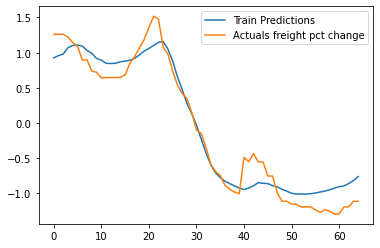

In [16]:
train_results.plot()

,Train Predictions,Ocean Freight rate
Validity From,,
2022-02-15,5607.168945,6448
2022-02-21,5689.220215,6448
2022-03-01,5745.590820,6448
2022-03-07,5974.104492,6348
2022-03-11,6052.028320,6148


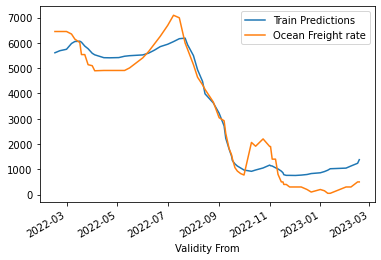

In [17]:
predictions_real=(train_results["Train Predictions"]*np.std(freight_df["Ocean Freight rate"]))+np.mean(freight_df["Ocean Freight rate"])
predictions_real=pd.DataFrame(predictions_real)
predictions_real.index=freight_df.iloc[3:,:].index
predictions_real["Ocean Freight rate"]=freight_df["Ocean Freight rate"]

predictions_real.plot()
predictions_real.head()

In [19]:
u=np.mean(freight_df["Ocean Freight rate"])
sigma=np.std(freight_df["Ocean Freight rate"])
u,sigma

(3286.3529411764707, 2506.4362781864206)

In [20]:
data_final.head()
data_final2=data_final.append({"Ocean Freight":0,"Day sin":0,"Day cos":0,"Year sin":0,"Year cos":0},ignore_index=True)
xtrain2,ytrain2=df_to_X_y2(data_final2,window_size=3)
train_predictions2 = model.predict(xtrain2).flatten()
train_predictions2

3/3 [==============================] - 0s 4ms/step


C:\Users\OCTAVIO\AppData\Local\Temp\ipykernel_15752\1267037105.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_final2=data_final.append({"Ocean Freight":0,"Day sin":0,"Day cos":0,"Year sin":0,"Year cos":0},ignore_index=True)


array([ 0.9259424 ,  0.9586787 ,  0.9811692 ,  1.0723398 ,  1.1034293 ,
        1.1087617 ,  1.0928133 ,  1.0315332 ,  0.98973954,  0.9178941 ,
        0.89378756,  0.8484371 ,  0.84667695,  0.85004133,  0.87125933,
        0.87992364,  0.89218706,  0.9205258 ,  0.96746004,  1.0229154 ,
        1.0604775 ,  1.1020733 ,  1.1479081 ,  1.1567981 ,  1.0512611 ,
        0.88207674,  0.6579852 ,  0.47513947,  0.27844247,  0.13463187,
       -0.02765131, -0.22713624, -0.42276567, -0.5904361 , -0.70529014,
       -0.77429396, -0.8256863 , -0.8605458 , -0.89173555, -0.92351633,
       -0.94363576, -0.9230768 , -0.89091825, -0.8453267 , -0.85566425,
       -0.8600802 , -0.88791335, -0.9061721 , -0.9409275 , -0.9671065 ,
       -0.99690354, -1.0074015 , -1.0076487 , -1.0090587 , -1.003331  ,
       -0.99384844, -0.97894317, -0.9669004 , -0.94746256, -0.9259136 ,
       -0.90306133, -0.8932    , -0.8596313 , -0.8166505 , -0.7602108 ,
       -0.73268044], dtype=float32)

In [21]:
first_march=((((train_predictions2[65]*sigma)+u)/502)-1)*100
print("La variación porcentual para los primeros días de marzo es de aproximadamente: "+str(first_march)+"%")

La variación porcentual para los primeros días de marzo es de aproximadamente: 188.83189365948616%
